## Data Overview ##

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense
import shap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [49]:
# Load the CSV files
credit = pd.read_csv('credit_info.csv')

print(credit.head())

   Gender    Age   Debt  Married  BankCustomer     Industry Ethnicity  \
0       1  30.83  0.000        1             1  Industrials     White   
1       0  58.67  4.460        1             1    Materials     Black   
2       0  24.50  0.500        1             1    Materials     Black   
3       1  27.83  1.540        1             1  Industrials     White   
4       1  20.17  5.625        1             1  Industrials     White   

   YearsEmployed  PriorDefault  Employed  CreditScore  DriversLicense  \
0           1.25             1         1            1               0   
1           3.04             1         1            6               0   
2           1.50             1         0            0               0   
3           3.75             1         1            5               1   
4           1.71             1         0            0               0   

        Citizen  ZipCode  Income  Approved  
0       ByBirth      202       0         1  
1       ByBirth       43     560

## Basic Model ##

In [50]:
# Load data
credit = pd.read_csv('credit_info.csv')

# Convert categorical variables to numerical
label_encoders = {}
categorical_columns = ['Gender', 'Married', 'BankCustomer', 'Industry', 'Ethnicity', 'Citizen']  # list all categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    credit[col] = le.fit_transform(credit[col])
    label_encoders[col] = le

# Handle missing values
credit.fillna(credit.mean(), inplace=True)  # Replace NaNs with the mean of the column

# Split the data into features and target
X = credit.drop('Approved', axis=1)
y = credit['Approved']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test data
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

# Display the feature importance
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nFeature Importances:")
print(feature_importances)

Accuracy: 0.7681159420289855
Confusion Matrix:
[[56 12]
 [20 50]]

Feature Importances:
                importance
PriorDefault      0.541459
Income            0.064718
YearsEmployed     0.057311
Debt              0.055386
Age               0.053273
ZipCode           0.052079
CreditScore       0.040450
Industry          0.038597
Citizen           0.037624
Ethnicity         0.025740
DriversLicense    0.021040
BankCustomer      0.012323
Gender            0.000000
Married           0.000000
Employed          0.000000


#### Add in clustering ###

In [51]:
# Example of scaling
scaler = StandardScaler()
credit['Income_scaled'] = scaler.fit_transform(credit[['Income']])

# Example of binning
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform', subsample=200)
credit['Age_bins'] = binner.fit_transform(credit[['Age']])

# Example of clustering
kmeans = KMeans(n_clusters=3, random_state=42)
credit['cluster'] = kmeans.fit_predict(credit[['Income', 'YearsEmployed']])

# Re-training the model with new features
X = credit.drop('Approved', axis=1)
y = credit['Approved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"New Accuracy: {accuracy}")

New Accuracy: 0.7976878612716763


## Improved Model ##
#### Add in categorical and numerical feature engineering ####

In [52]:
# Load data
credit = pd.read_csv('credit_info.csv')

# One-hot encode the categorical variables
credit_encoded = pd.get_dummies(credit, columns=['Industry', 'Ethnicity', 'Citizen', 'Gender', 'Married', 'BankCustomer'])

# Optionally add polynomial features
poly = PolynomialFeatures(degree=2)
credit_poly = poly.fit_transform(credit_encoded.drop('Approved', axis=1))

# Scale features
scaler = StandardScaler()
credit_scaled = scaler.fit_transform(credit_poly)

# Apply PCA
pca = PCA(n_components=0.95)
credit_pca = pca.fit_transform(credit_scaled)

# Add clustering as a feature
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(credit_scaled)
credit_pca = np.column_stack((credit_pca, clusters))

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(credit_pca, credit_encoded['Approved'], test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.8333333333333334


#### Add in Keras model with epochs and shap analysis ####

Epoch 1/10


c:\Users\hcrof\School\stat486\stat486\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6836 - loss: 0.6199 - val_accuracy: 0.8393 - val_loss: 0.4235
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8950 - loss: 0.2939 - val_accuracy: 0.8393 - val_loss: 0.3995
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9469 - loss: 0.1743 - val_accuracy: 0.8214 - val_loss: 0.3582
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9499 - loss: 0.1270 - val_accuracy: 0.8214 - val_loss: 0.4374
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9543 - loss: 0.1193 - val_accuracy: 0.8393 - val_loss: 0.4174
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9769 - loss: 0.0806 - val_accuracy: 0.8036 - val_loss: 0.4438
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9651 - loss: 0.0948 - val_accuracy: 0.8214 - val_loss: 0.4752
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9786 - loss: 0.0673 - val_accuracy: 0.8393 - val_loss: 0.4953
Epo

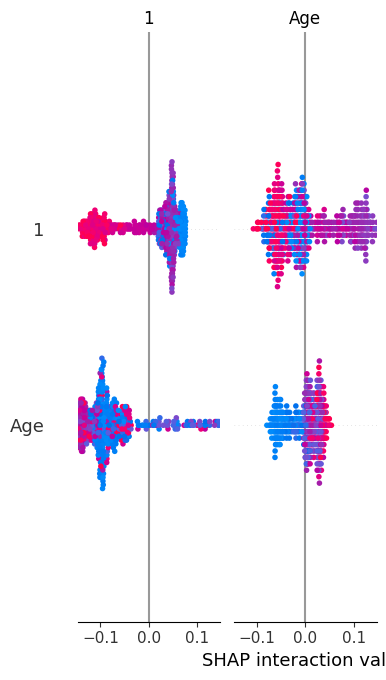

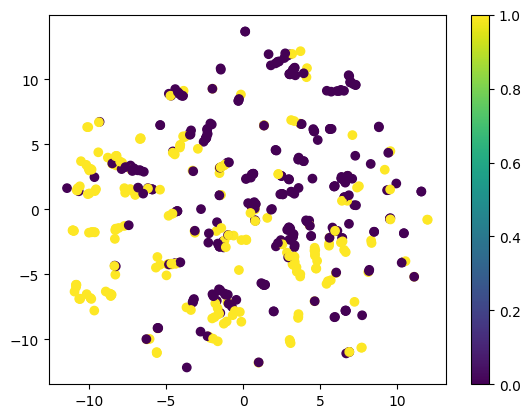

In [53]:
# Additional machine learning models
svm_model = SVC(kernel='linear', probability=True)
knn_model = KNeighborsClassifier()
gb_model = GradientBoostingClassifier()

svm_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Simple Keras model
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dl_model = build_model(X_train.shape[1])
dl_model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.1)

# SHAP analysis for RandomForest
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=poly.get_feature_names_out())

# t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
X_tsne = tsne.fit_transform(X_train)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train)
plt.colorbar()
plt.show()